In [9]:
# generate_kara_masks.py  – versione corretta
import os
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from icenet.data.sic.mask import Masks

hemi = "north"
mask_dir = f"./data/masks/{hemi}/masks"
os.makedirs(mask_dir, exist_ok=True)

# 1 · poligono del mare di Kara in EPSG:6931 (EASE‑2 North)
kara_poly = (
    gpd.read_file("Kara_sea_iho.zip")
      .to_crs("EPSG:6931")
      .unary_union
)

/var/tmp/ipykernel_31746/3477328394.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  .unary_union


In [10]:

# 2 · centri delle 432×432 celle IceNet in metri (x = est‑ovest, y = nord‑sud)
shape = (432, 432)
step  = 25_000                     # 25 km
cols  = np.arange(shape[1]) - shape[1]/2 + 0.5
rows  = np.arange(shape[0]) - shape[0]/2 + 0.5
x_coords = cols * step             # ‑5 387 500 … +5 387 500 m
y_coords = rows * step             # idem per y
xc, yc   = np.meshgrid(x_coords, y_coords, indexing="xy")

In [19]:
step   = 25_000                 # 25 km
shape  = (432, 432)
cols   = np.arange(shape[1]) - shape[1]/2 + 0.5
rows   = np.arange(shape[0]) - shape[0]/2 + 0.5

x_coords =  cols * step          #  -5 387 500  …  +5 387 500  m
y_coords = -rows * step          #  +5 387 500  …  -5 387 500  m  ← segno invertito

xc, yc = np.meshgrid(x_coords, y_coords, indexing="xy")

In [20]:

# 3 · maschera Kara: True dentro il poligono, False fuori
flat_mask = [
    kara_poly.contains(Point(x, y)) for x, y in zip(xc.ravel(), yc.ravel())
]
kara_mask = np.array(flat_mask, dtype=bool).reshape(shape)

# 4 · interseca con le 12 active_grid_cell_mask esistenti
m = Masks(north=True, south=False)

In [21]:

for mm in range(1, 13):
    p = os.path.join(mask_dir, f"active_grid_cell_mask_{mm:02d}.npy")
    base = np.load(p)
    pout = os.path.join(mask_dir, f"active_grid_cell_mask_{mm:02d}_pout.npy")
    np.save(pout, base & kara_mask)

print("Maschere mensili per il mare di Kara pronte.")


Maschere mensili per il mare di Kara pronte.


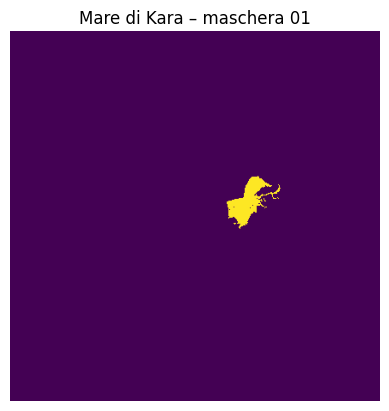

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ⇩⇩  METTI QUI IL PERCORSO CORRETTO  ⇩⇩
mask_dir = "data/masks/north/masks"

for mm in range(1, 2):
    mask_path = os.path.join(mask_dir, f"active_grid_cell_mask_{mm:02d}_pout.npy")
    if not os.path.isfile(mask_path):
        print(f"Non trovato: {mask_path}")
        continue

    mask = np.load(mask_path)

    # figura singola, nessun subplot
    plt.figure()
    plt.imshow(mask, origin="lower")
    plt.title(f"Mare di Kara – maschera {mm:02d}")
    plt.axis("off")
    plt.show()


In [26]:
mask.shape

(432, 432)

In [30]:
np.count_nonzero(mask == 1)

1391

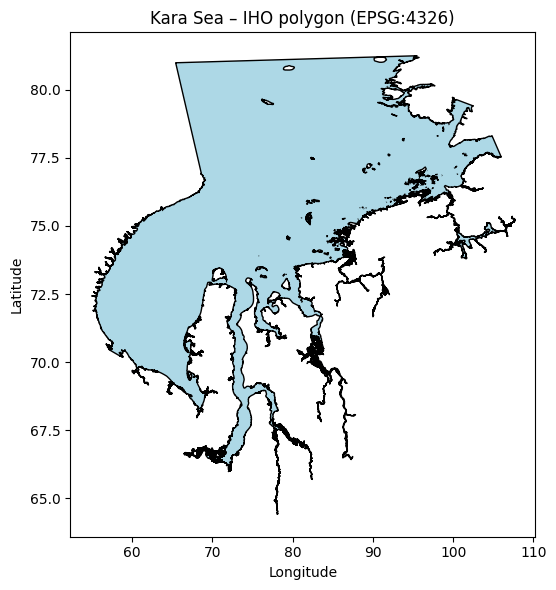

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. legge direttamente lo ZIP (CRS originale WGS84: EPSG:4326)
kara = gpd.read_file("Kara_sea_iho.zip")

# 2. disegna il poligono
fig, ax = plt.subplots(figsize=(6, 6))
kara.plot(ax=ax, edgecolor="black", facecolor="lightblue")
ax.set_title("Kara Sea – IHO polygon (EPSG:4326)")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
plt.tight_layout(); plt.show()


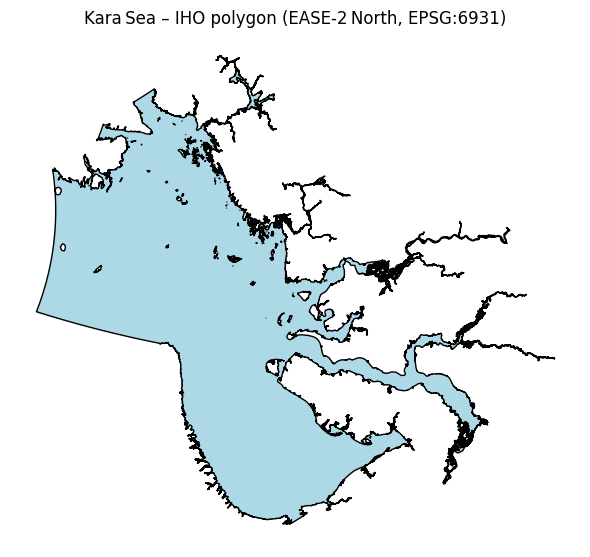

In [24]:
kara_ease = kara.to_crs(6931)

fig, ax = plt.subplots(figsize=(6, 6))
kara_ease.plot(ax=ax, edgecolor="black", facecolor="lightblue")
ax.set_title("Kara Sea – IHO polygon (EASE‑2 North, EPSG:6931)")
ax.set_axis_off()          # le coordinate 6931 sono in metri, spesso poco leggibili
plt.tight_layout(); plt.show()
